In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

import summarize

In [2]:
df = pd.read_csv('fitbit/tidy.csv')
# add data dictionary!

In [3]:
# We decided to remove the food logs because they were mostly 0

In [4]:
df.head(5)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [5]:
summarize.df_summary(df)

--- Shape: (225, 10)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB
--- Descriptions
           date calories_burned steps    distance      floors  \
count       225             225   225  225.000000  225.000000   
unique      225             207   213         NaN         NaN   
top     8/10/18           2,145     0         NaN         NaN   
freq          1               4    12         NaN         NaN   
mea

In [6]:
# change date to datetime
# remove commas to change to numeric dtypes

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df = df.set_index('date')

In [9]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566
2018-04-27,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2018-04-28,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
2018-04-29,"2,851","1,639",0.77,0,891,122,0,0,602
2018-04-30,"2,825","1,323",0.62,0,880,104,0,0,540


In [10]:
df['calories_burned'] = df['calories_burned'].str.replace(',','')
df['steps'] = df['steps'].str.replace(',','')
df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
df['activity_calories'] = df['activity_calories'].str.replace(',','')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 17.6+ KB


In [12]:
df.dtypes

calories_burned            object
steps                      object
distance                  float64
floors                      int64
minutes_sedentary          object
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories          object
dtype: object

In [13]:
# change the data types to numeric dtypes
df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)

In [14]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
floors                      int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
dtype: object

In [15]:
# Add nnew column to track total minutes accounted for. There are 1440 minutes in a day
# Use this column to track how long they were wearing the fitbit
df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']

In [16]:
df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged
date,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890


In [17]:
# distance per step - the average person takes a stride of about 2.1 to 2.5 feet 
# (woman's average 2.2) (average man)
# (our person takes a stride of 2.4816, probably a make)
df['distance_per_step'] = (df['distance'] / df['steps']) 

In [18]:
# dont know if miles or km
# mile = 2.5 step stride
# km = 1.5 step stride

# if we assume that steps are in miles, we can assume the participant is an American, therefore cn take American holidays into consideration
# taking calorie intake and stride into account, can find approximate weight for either male or female


In [19]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469


In [20]:
# finish this
def prepare_data(df):
    df = pd.read_csv('fitbit/tidy.csv')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index(df['date'])
    df['calories_burned'] = df['calories_burned'].str.replace(',','')
    df['steps'] = df['steps'].str.replace(',','')
    df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
    df['activity_calories'] = df['activity_calories'].str.replace(',','')
    df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)
    df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']
    df['distance_per_step'] = df['distance'] / df['steps']
    return df

In [21]:
# day of the week vs floor count - is there a spike difference?

In [22]:
df.head(1)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471


In [23]:
# look at the steps average in days, weeks, and months

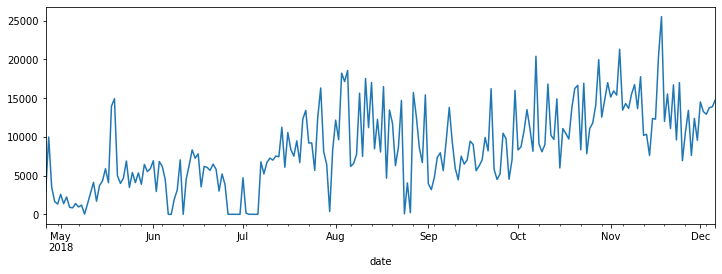

In [24]:
df['steps'].resample("D").mean().plot(figsize=(12,4))

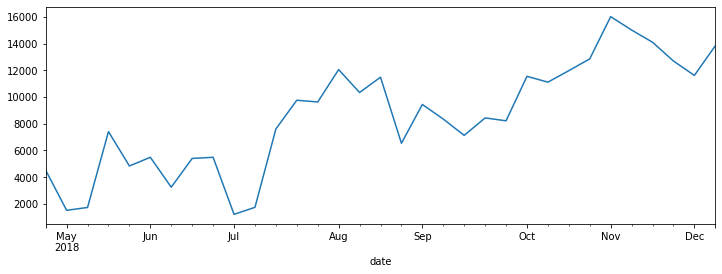

In [25]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

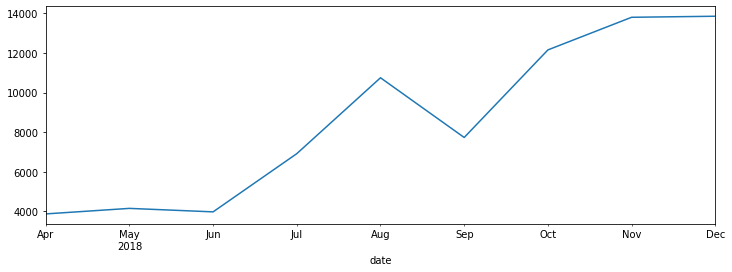

In [26]:
df['steps'].resample("M").mean().plot(figsize=(12,4))

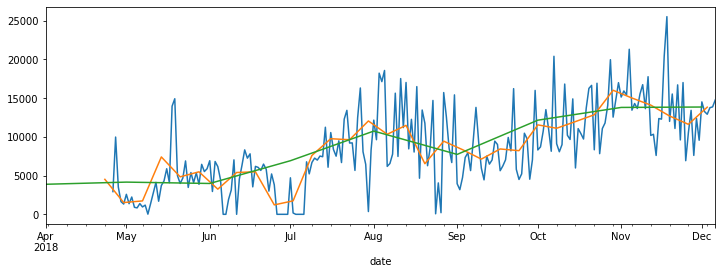

In [27]:
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))

In [28]:
# look for days when there is a zero value
df.steps.sort_values().head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64

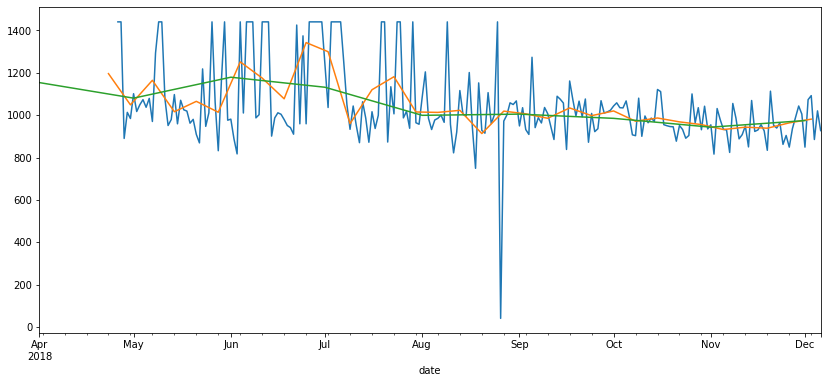

In [29]:
# started off strong in the beginning and then began to fall off the wagon a bit in the end
df['total_minutes_logged'].resample("D").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("W").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("M").mean().plot(figsize=(14,6))

In [30]:
df.total_minutes_logged.sort_values().head(15)

date
2018-08-26     41
2018-08-18    749
2018-11-02    816
2018-06-03    817
2018-08-11    822
2018-11-07    824
2018-05-28    832
2018-11-19    834
2018-09-16    838
2018-11-26    849
2018-12-01    849
2018-11-13    850
2018-11-24    862
2018-05-22    869
2018-07-12    870
Name: total_minutes_logged, dtype: int64

In [31]:
# which month(s) has lowest amount of logged activity
df1 = df.resample("M").mean()
df1.sort_values(by='total_minutes_logged', ascending=True)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.133333,66.633333,2111.433333,943.166667,0.000480
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333,0.000476
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.032258,54.903226,1779.903226,984.741935,0.000472
2018-08-31,3753.612903,10743.967742,5.075161,12.451613,717.354839,216.419355,13.580645,51.677419,1901.935484,999.032258,0.000472
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,13.266667,26.733333,1346.866667,1004.700000,0.000472
2018-05-31,3116.032258,4156.032258,1.960000,1.387097,908.483871,151.709677,11.677419,8.225806,984.967742,1080.096774,0.000472
2018-07-31,3317.290323,6916.741935,3.263871,5.935484,920.000000,171.580645,17.483871,22.483871,1331.903226,1131.548387,0.000472
2018-04-30,3067.800000,3877.000000,1.826000,4.600000,995.600000,138.600000,13.600000,5.600000,916.800000,1153.400000,0.000470
2018-06-30,2972.600000,3980.533333,1.878000,3.233333,1012.233333,152.166667,10.000000,4.466667,923.833333,1178.866667,0.000472


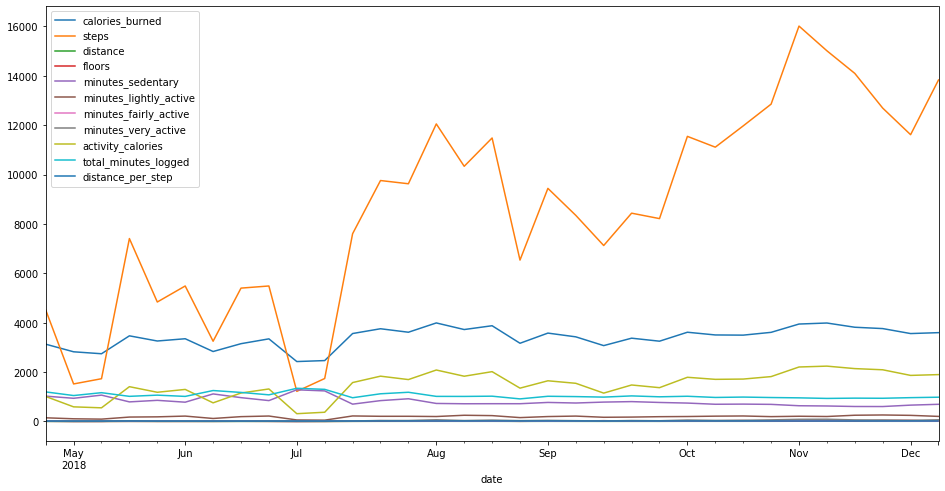

In [32]:
fig = df.resample("W").mean().plot(figsize=(16,8))

In [33]:
df.sort_index().steps.sort_values(ascending=True).head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64

In [34]:
# calories_burned
# steps
# distance
# floors
# distance per step

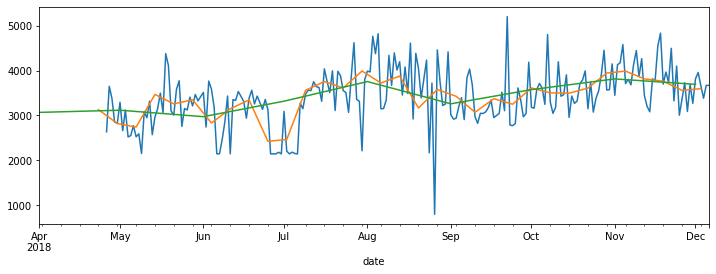

In [35]:
df['calories_burned'].resample("D").mean().plot(figsize=(12,4))
df['calories_burned'].resample("W").mean().plot(figsize=(12,4))
df['calories_burned'].resample("M").mean().plot(figsize=(12,4))

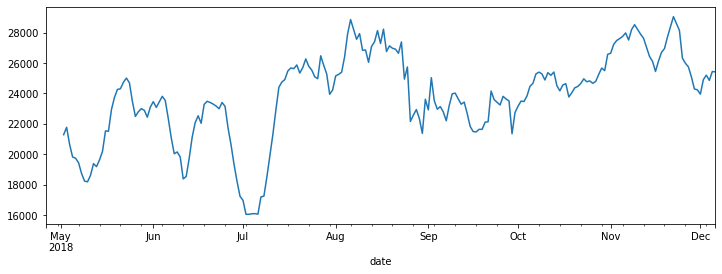

In [36]:
# every 7 days compared to resample("D")
df['calories_burned'].rolling(7).sum().plot(figsize=(12,4))

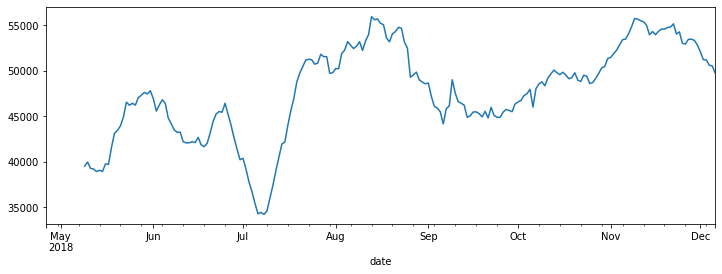

In [37]:
# every two weeks
df['calories_burned'].rolling(14).sum().plot(figsize=(12,4))

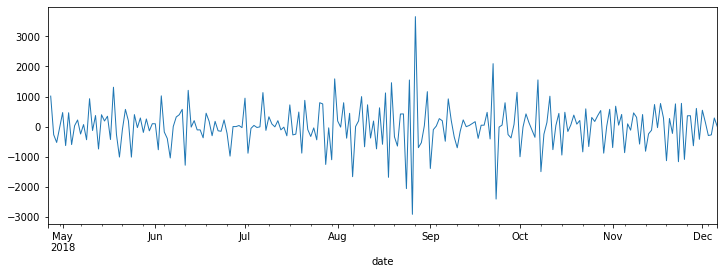

In [38]:
# difference between day to day
# something around the end of august
# task: look at month of august
df['calories_burned'].resample("D").mean().diff().plot(figsize=(12,4), linewidth=1)

In [39]:
df['weekday'] = df.index.weekday_name

In [40]:
df['month'] = df.index.month

In [41]:
df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
date,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,Thursday,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,Friday,4


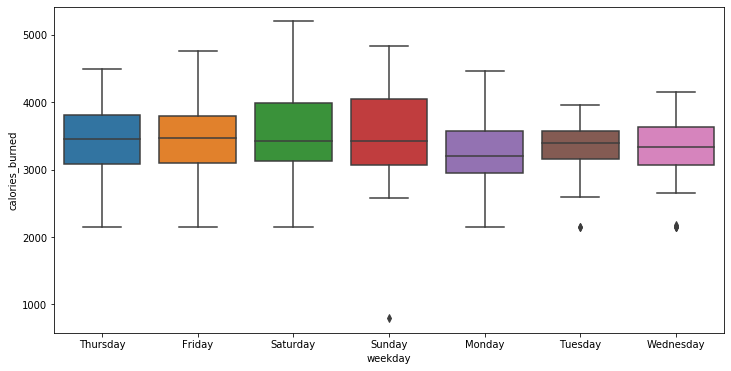

In [42]:
# burned more calories during the weekends
# a few outliers on Sundays/Tuesdays/Wednesdays
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='calories_burned')

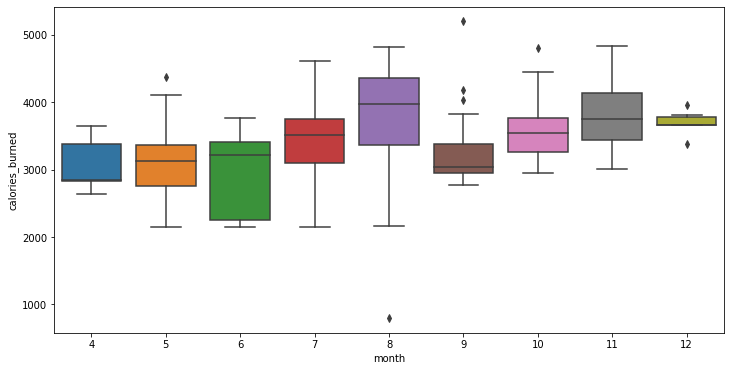

In [43]:
# more outliers each month for calories burned
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='calories_burned')

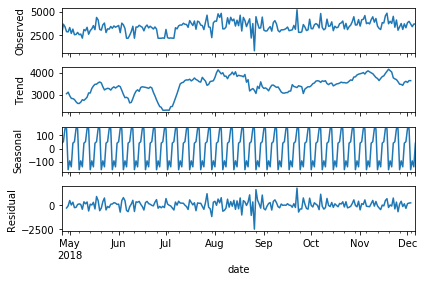

In [44]:
# no real trend in calories burned..
# no idea what seasonal is telling me
# residual looks very similar to observed 
# task: look at month
decomp = sm.tsa.seasonal_decompose(df['calories_burned'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

In [45]:
# look at the trend for monthly

# decomp = sm.tsa.seasonal_decompose(df['calories_burned'].resample("M").mean(), model='additive')
# fig = decomp.plot()
# plt.show()

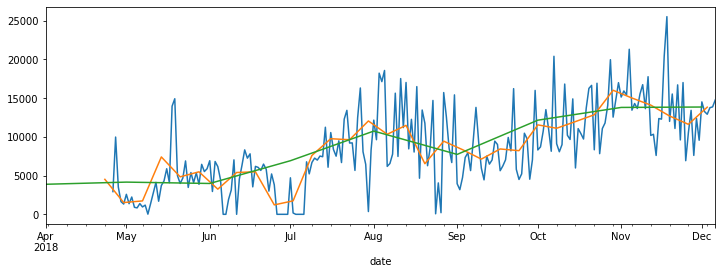

In [46]:
# steps
# uphill trend
# what do the peaks and valleys mean?
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))

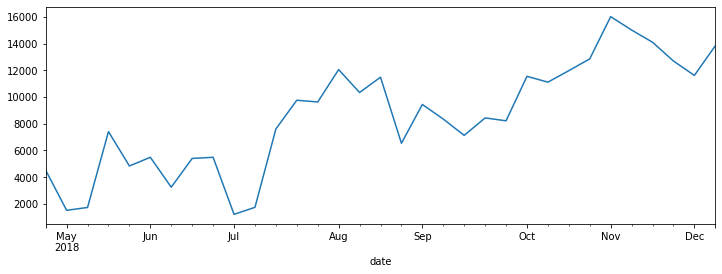

In [47]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

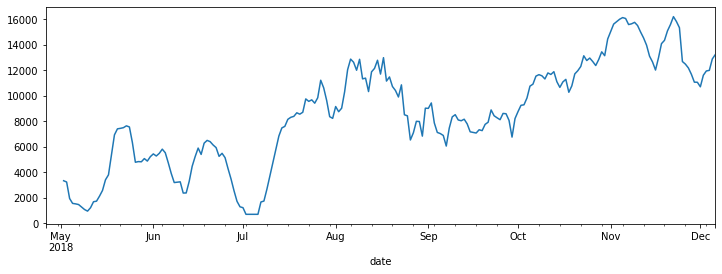

In [48]:
# how is this different from week? More rigidity in lines for this one
df['steps'].rolling(7).mean().plot(figsize=(12,4))

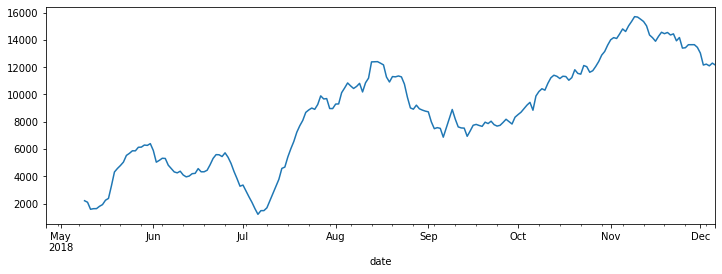

In [49]:
# every 2 weeks, see a clearer trend
df['steps'].rolling(14).mean().plot(figsize=(12,4))

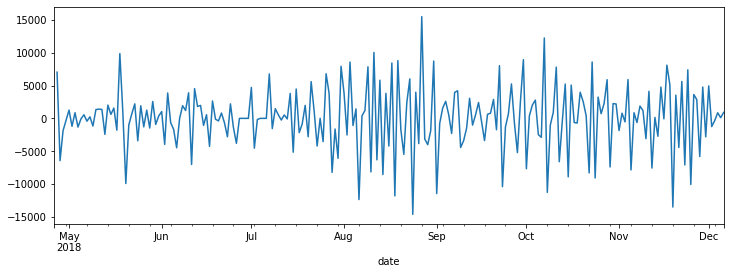

In [50]:
# there are differences from day to day that grow as the months go, there are more periods of negative the longer the wearer has the fitbit
df['steps'].resample("D").mean().diff().plot(figsize=(12,4))

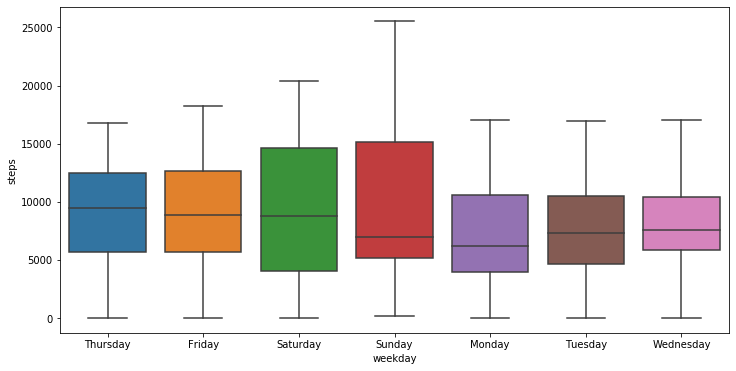

In [51]:
# again, can see that some days more active that others
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='steps')

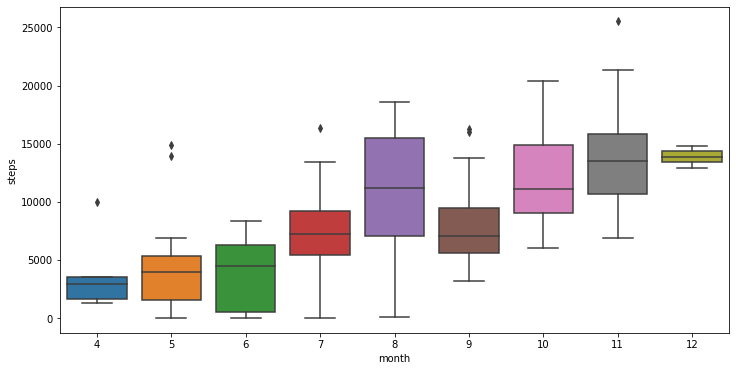

In [52]:
# outliers
# august 
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='steps')

In [53]:
# august is 4th highest in steps --> look at box plot
# deal with outliers? figure out what they are 
df1.sort_values(by='steps', ascending=False)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333,0.000476
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.133333,66.633333,2111.433333,943.166667,0.000480
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.032258,54.903226,1779.903226,984.741935,0.000472
2018-08-31,3753.612903,10743.967742,5.075161,12.451613,717.354839,216.419355,13.580645,51.677419,1901.935484,999.032258,0.000472
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,13.266667,26.733333,1346.866667,1004.700000,0.000472
2018-07-31,3317.290323,6916.741935,3.263871,5.935484,920.000000,171.580645,17.483871,22.483871,1331.903226,1131.548387,0.000472
2018-05-31,3116.032258,4156.032258,1.960000,1.387097,908.483871,151.709677,11.677419,8.225806,984.967742,1080.096774,0.000472
2018-06-30,2972.600000,3980.533333,1.878000,3.233333,1012.233333,152.166667,10.000000,4.466667,923.833333,1178.866667,0.000472
2018-04-30,3067.800000,3877.000000,1.826000,4.600000,995.600000,138.600000,13.600000,5.600000,916.800000,1153.400000,0.000470


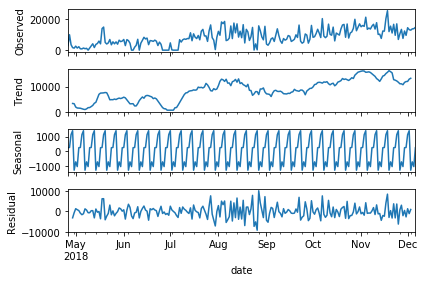

In [54]:
# uneven trend in steps, lots of noise (?), 
decomp = sm.tsa.seasonal_decompose(df['steps'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

In [55]:
# 5/9 only took 21 steps. maybe fill with mean value?
# 5/18-19 had sig more steps than average
df_mo = df.resample("D").mean()
d = df_mo.sort_values(by='month')
d[d.month == 5].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-05-09,2153,21,0.01,0,1438,2,0,0,8,1440,0.000476,5
2018-05-05,2551,833,0.39,0,969,68,0,0,326,1037,0.000468,5
2018-05-04,2522,904,0.43,1,1012,61,0,0,269,1073,0.000476,5
2018-05-07,2524,952,0.45,0,907,63,0,0,283,970,0.000473,5
2018-05-08,2591,1187,0.56,2,1221,53,17,2,410,1293,0.000472,5
2018-05-10,3081,1364,0.64,0,1295,136,5,4,924,1440,0.000469,5
2018-05-02,2660,1372,0.65,0,927,90,0,0,419,1017,0.000474,5
2018-05-06,2771,1383,0.65,0,976,103,0,0,506,1079,0.000470,5
2018-05-13,2572,1689,0.80,0,895,84,0,0,394,979,0.000474,5


In [56]:
# incomplete month, wide range of steps
# 4/27 higher than average
d[d.month == 4].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469,4
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470,4
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,4
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,4


In [57]:
# 7/3 - 7/6 no steps taken --> fill with mean value?
# 7/2 has sig less steps taken
# end of month has higher than average steps, days stagger
d[d.month == 7].sort_values(by='steps').tail(10)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-07-17,3760,8377,3.95,12,646,258,8,25,1803,937,0.000472,7
2018-07-23,3553,9203,4.34,5,748,204,23,31,1597,1006,0.000472,7
2018-07-24,3510,9215,4.35,6,1203,193,15,29,1551,1440,0.000472,7
2018-07-19,3993,9484,4.47,4,1116,243,57,24,2093,1440,0.000471,7
2018-07-16,4037,10551,4.98,4,714,204,51,47,2084,1016,0.000472,7
2018-07-14,3622,11239,5.30,10,709,203,39,35,1770,986,0.000472,7
2018-07-21,3983,12279,5.79,10,569,184,37,83,2162,873,0.000472,7
2018-07-26,3864,12467,5.88,10,704,214,11,58,1962,987,0.000472,7
2018-07-22,3883,13418,6.33,19,839,210,16,69,2015,1134,0.000472,7


In [58]:
# three days with lots of exercise
d[d.month == 9].sort_values(by='steps').tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-09-20,3517,9920,4.68,8,844,156,10,56,1565,1066,0.000472,9
2018-09-26,3613,10466,4.94,9,707,163,3,63,1677,936,0.000472,9
2018-09-08,4031,13798,6.65,16,634,237,16,76,2230,963,0.000482,9
2018-09-30,4184,15991,7.54,9,652,254,45,72,2504,1023,0.000472,9
2018-09-22,5199,16219,7.65,10,581,319,78,98,3596,1076,0.000472,9


In [59]:
# in general, november very active month for steps taken, range from 6921 - 25512
d[d.month == 11].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-11-25,3005,6921,3.26,11,614,281,3,6,1306,904,0.000471,11
2018-11-14,3081,7598,3.58,15,835,214,8,12,1250,1069,0.000471,11
2018-11-28,3088,7602,3.59,16,717,272,0,0,1361,989,0.000472,11
2018-11-30,3269,9559,4.51,14,699,288,12,6,1577,1005,0.000472,11
2018-11-23,3325,9602,4.53,16,660,269,23,12,1619,964,0.000472,11
2018-11-12,3444,10184,4.82,19,651,244,14,40,1705,949,0.000473,11
2018-11-13,3202,10330,4.87,16,615,199,10,26,1376,850,0.000471,11
2018-11-26,3364,10563,5.64,20,587,210,10,42,1605,849,0.000534,11
2018-11-21,3738,11079,5.16,4,582,328,9,33,2101,952,0.000466,11


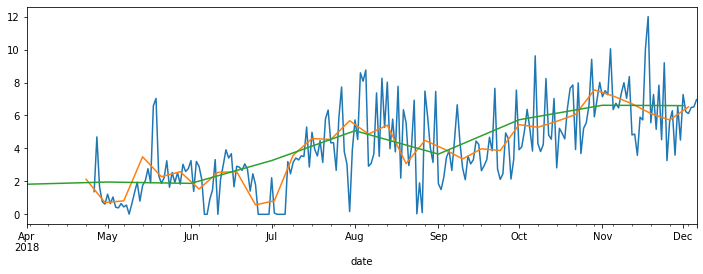

In [60]:
# distance 
df.distance.resample("D").mean().plot(figsize=(12,4))
df.distance.resample("W").mean().plot(figsize=(12,4))
df.distance.resample("M").mean().plot(figsize=(12,4))

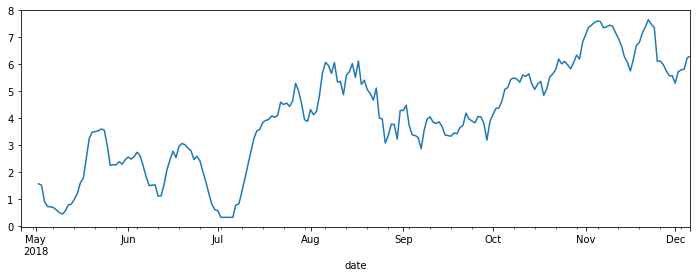

In [61]:
# one week/7 days
df.distance.rolling(7).mean().plot(figsize=(12,4))

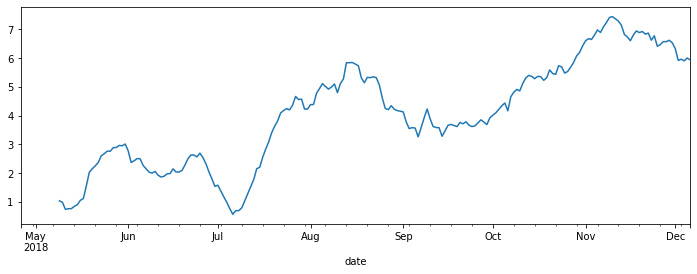

In [62]:
# every two weeks
df.distance.rolling(14).mean().plot(figsize=(12,4))

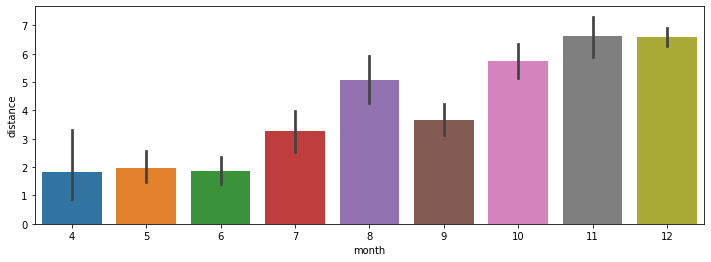

In [63]:
# follows trend of other vars, steps and calories burned, makes sense
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance')

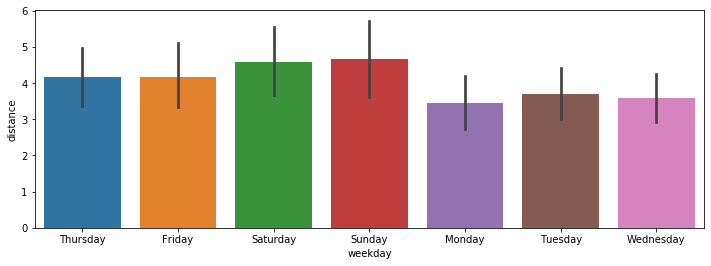

In [64]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance')

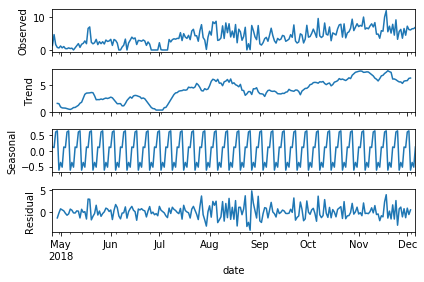

In [65]:
decomp = sm.tsa.seasonal_decompose(df['distance'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

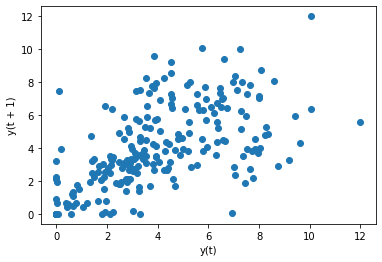

In [66]:
pd.plotting.lag_plot(df.distance.resample('D').mean(), lag=1)

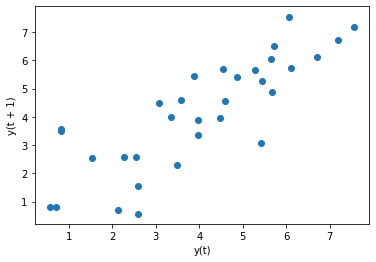

In [67]:
pd.plotting.lag_plot(df.distance.resample('W').mean(), lag=1)

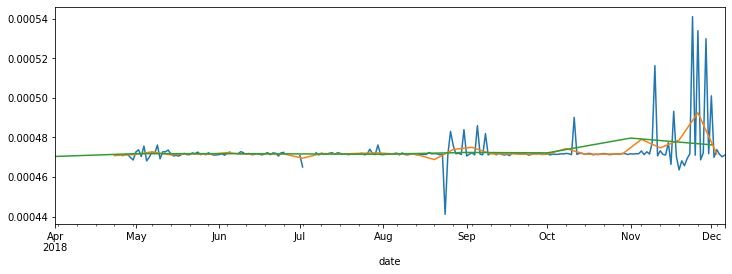

In [68]:
# distance per steps
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("M").mean().plot(figsize=(12,4))

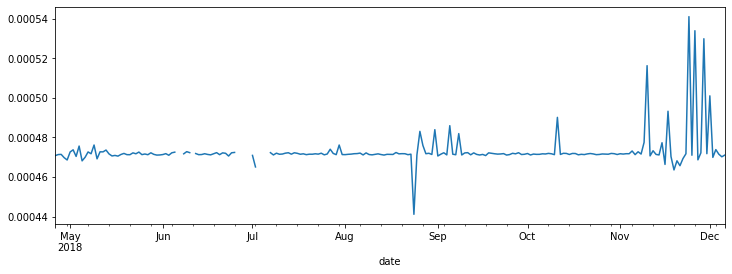

In [69]:
# gaps in the data around July, missing data for a few days
# large spike in distance per step around the end of the data
# dip around end of august, seen this before
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))

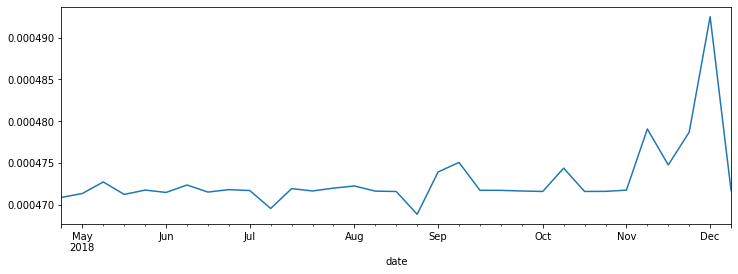

In [70]:
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))

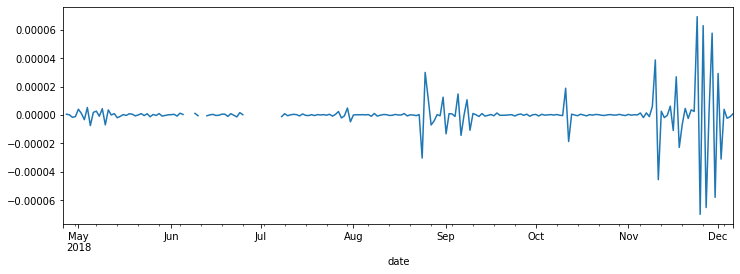

In [71]:
# steady in most parts, then large differences
df['distance_per_step'].resample("D").mean().diff().plot(figsize=(12,4))

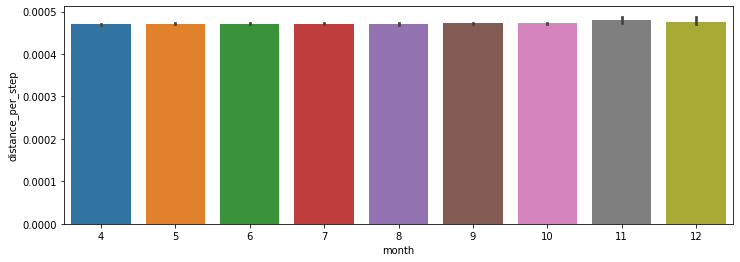

In [72]:
# look at error bars, but cant get much from them
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance_per_step')

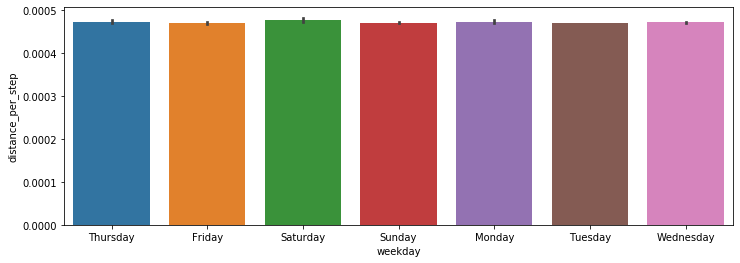

In [73]:
# look at error bars, but cant get much from them
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance_per_step')

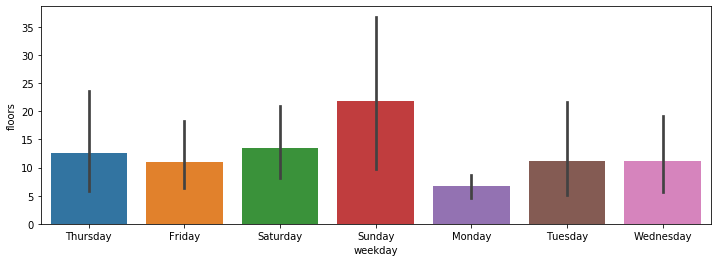

In [74]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='floors')

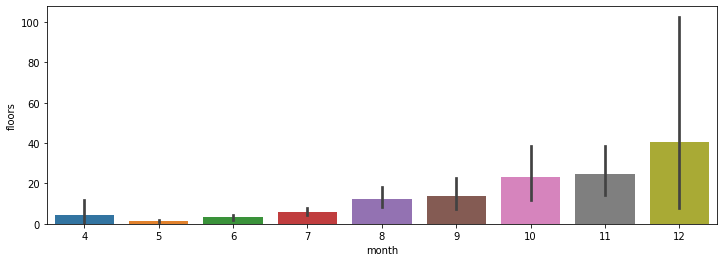

In [75]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='floors')

In [76]:
#Task: fill zeros ffill or bfill?
df.head()
# what do we want to predict? 
# predict steps

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
date,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,Thursday,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,Friday,4
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471,Saturday,4
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470,Sunday,4
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469,Monday,4


In [77]:
df.activity_calories.value_counts()

0       9
1125    2
1684    2
1427    2
1630    2
1068    2
1172    2
1330    2
1127    2
1962    2
1530    2
2224    1
1714    1
1196    1
1195    1
1705    1
1185    1
1175    1
2717    1
1689    1
2228    1
2436    1
2958    1
1678    1
1677    1
1669    1
2692    1
1663    1
2686    1
1715    1
       ..
1287    1
2305    1
1278    1
1787    1
822     1
2361    1
1852    1
829     1
2418    1
1389    1
1388    1
1895    1
1382    1
1376    1
1375    1
2398    1
2907    1
1882    1
3344    1
853     1
852     1
1874    1
1361    1
1872    1
1354    1
1074    1
326     1
1298    1
1343    1
1266    1
Name: activity_calories, Length: 207, dtype: int64

#### Modeling

In [78]:
# fix prepare index part
df.shape

(225, 13)

In [79]:
df = df.reset_index()

In [80]:
df

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
0,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,Thursday,4
1,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,Friday,4
2,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471,Saturday,4
3,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470,Sunday,4
4,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469,Monday,4
5,2018-05-01,3292,2581,1.22,0,919,167,13,2,1068,1101,0.000473,Tuesday,5
6,2018-05-02,2660,1372,0.65,0,927,90,0,0,419,1017,0.000474,Wednesday,5
7,2018-05-03,3121,2232,1.05,0,876,157,16,0,1006,1049,0.000470,Thursday,5
8,2018-05-04,2522,904,0.43,1,1012,61,0,0,269,1073,0.000476,Friday,5
9,2018-05-05,2551,833,0.39,0,969,68,0,0,326,1037,0.000468,Saturday,5


In [81]:
X = df['date']
y = df['steps']

In [84]:
def split_data(df, train_prop=.70):
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [85]:
train, test = split_data(df)
display(train, test)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
0,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,Thursday,4
1,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,Friday,4
2,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471,Saturday,4
3,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470,Sunday,4
4,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469,Monday,4
5,2018-05-01,3292,2581,1.22,0,919,167,13,2,1068,1101,0.000473,Tuesday,5
6,2018-05-02,2660,1372,0.65,0,927,90,0,0,419,1017,0.000474,Wednesday,5
7,2018-05-03,3121,2232,1.05,0,876,157,16,0,1006,1049,0.000470,Thursday,5
8,2018-05-04,2522,904,0.43,1,1012,61,0,0,269,1073,0.000476,Friday,5
9,2018-05-05,2551,833,0.39,0,969,68,0,0,326,1037,0.000468,Saturday,5


,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
157,2018-09-30,4184,15991,7.54,9,652,254,45,72,2504,1023,0.000472,Sunday,9
158,2018-10-01,3180,8307,3.92,8,813,201,5,24,1330,1043,0.000472,Monday,10
159,2018-10-02,3162,8702,4.10,9,872,141,11,34,1205,1058,0.000471,Tuesday,10
160,2018-10-03,3584,10729,5.06,6,773,186,7,69,1715,1035,0.000472,Wednesday,10
161,2018-10-04,3713,13511,6.37,7,772,152,15,95,1895,1034,0.000471,Thursday,10
162,2018-10-05,3603,11029,5.20,105,822,167,7,71,1684,1067,0.000471,Friday,10
163,2018-10-06,3246,8140,3.84,6,750,218,20,6,1343,994,0.000472,Saturday,10
164,2018-10-07,4799,20396,9.62,30,402,329,76,100,3344,907,0.000472,Sunday,10
165,2018-10-08,3299,9111,4.30,6,648,210,25,20,1513,903,0.000472,Monday,10
166,2018-10-09,3046,8076,3.81,7,900,130,15,35,1127,1080,0.000472,Tuesday,10


In [86]:
train.shape

(157, 14)

In [87]:
test.shape

(68, 14)

In [88]:
train.drop(columns=(['weekday', 'month']), inplace=True)

In [89]:
test.drop(columns=(['weekday', 'month']), inplace=True)

In [90]:
train.shape

(157, 12)

In [91]:
test.shape

(68, 12)

In [95]:
predictions = pd.DataFrame(test['steps'])

In [97]:
predictions['simple_average'] = train.steps.mean()

In [99]:
predictions.head()

,steps,simple_average
0,2931,6567.464968
1,9971,6567.464968
2,3521,6567.464968
3,1639,6567.464968
4,1323,6567.464968
